## 1. Maryland crime data
<p>Crime rates vary across space and time. The reasons crimes are committed in some places but not others can be difficult to detect because of complex socio-economic factors, but policymakers still need to understand how crime rates are changing from place to place and from time to time to inform their policies.   </p>
<p>Many government statistics, such as crime rates, come from nested datasets. Most US States are divided into counties (Alaska has “burrows,” and  Louisiana has “parishes”), and counties and county-level governments can vary within the same state. For example, one county might have a high population density and be urban, whereas a second county might have a low population density and be rural. </p>
<p>In this project we will use a form of regression called hierarchical modeling to capture and explore <a href="http://goccp.maryland.gov/crime-statistics/">crime statistics</a> collected by the State of Maryland to see if there is a linear trend in violent crime across the state between 1975 and 2016. These data come from the <a href="https://ccjs.umd.edu/research/maryland-data-analysis-center">Maryland Statistical Analysis Center</a>. </p>
<p>This figure shows population per county across the state of Maryland in 2016. By the end of the project, we will create a similar figure for each county's crime rate.</p>
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" alt="Map of Maryland counties and population"></p>
<p>Before running a regression analysis, we often need to tidy data. Everyday tidying tasks include renaming and reformatting columns. Luckily, the <a href="https://www.tidyverse.org/">Tidyverse</a> exists!</p>

In [12]:
# Load the packages
library(tidyverse)
library(lubridate)

# Read in the crime data
crime_raw <- read_csv("datasets/Violent_Crime_by_County_1975_to_2016.csv")

# Select and mutate columns the needed columns
crime_use <- crime_raw %>% 
    select(JURISDICTION, YEAR, POPULATION, crime_rate = `VIOLENT CRIME RATE PER 100,000 PEOPLE`) %>%
    mutate(YEAR_2 = year(mdy_hms(YEAR)))

# Peek at the data
head(crime_use)

Parsed with column specification:
cols(
  .default = col_double(),
  JURISDICTION = col_character(),
  YEAR = col_character()
)
See spec(...) for full column specifications.


JURISDICTION    YEAR                   POPULATION crime_rate YEAR_2
1 Allegany County 01/01/1975 12:00:00 AM 79655      178.3      1975  
2 Allegany County 01/01/1976 12:00:00 AM 83923      103.7      1976  
3 Allegany County 01/01/1977 12:00:00 AM 82102      154.7      1977  
4 Allegany County 01/01/1978 12:00:00 AM 79966      127.6      1978  
5 Allegany County 01/01/1979 12:00:00 AM 79721      138.0      1979  
6 Allegany County 01/01/1980 12:00:00 AM 80461      147.9      1980

## 2. Raw data and trend lines
<p>Before running a regression or building a model, it's a good idea to explore the data. Exploratory data analysis (EDA) will help us see outliers, possible data errors, or trends. There is no single coding technique for EDA, but plotting the data is a great first step. A picture (or well-designed figure) can be worth a thousand summary statistics!</p>
<p>Let's plot the crime rate over time for each county and add a linear trend line.</p>

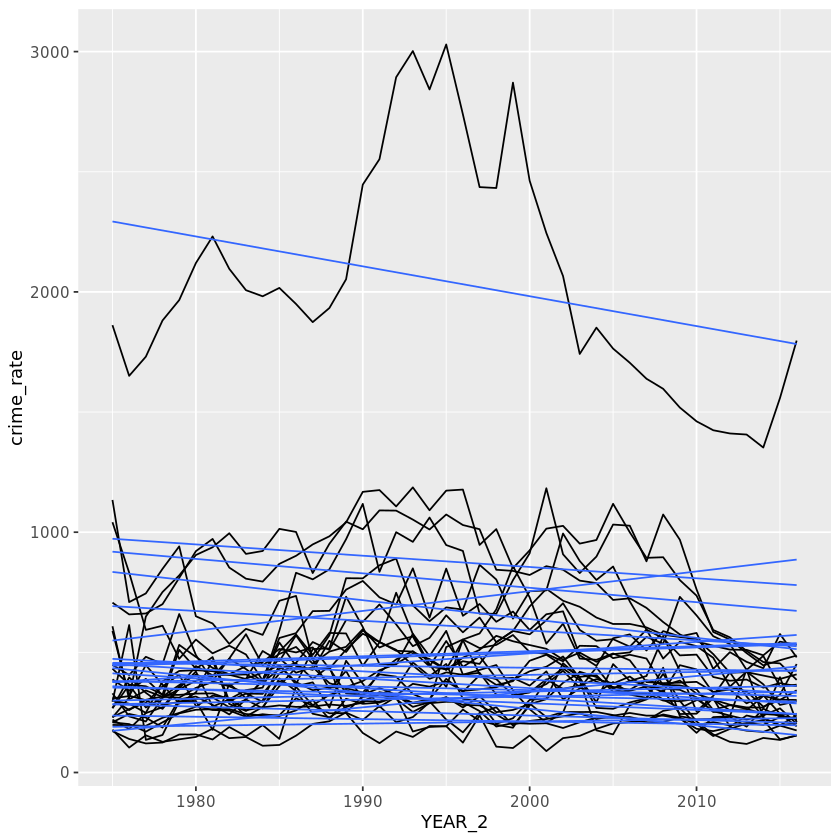

In [14]:
# Plot the data and linear trend lines
ggplot(crime_use, aes(x = YEAR_2, y = crime_rate, group = JURISDICTION)) + 
    geom_line() + 
    stat_smooth(method = 'lm', se = FALSE, size = 0.5)

## 3. Re-scale the data
<p>Prior to building a linear mixed-effects regression model, we need to re-scale the <code>YEAR_2</code> variable. In the raw data, <code>YEAR_2</code> starts at 1976, but regression models work best when the intercept is near zero. If we try to use <code>YEAR_2</code> without re-scaling it, the model will fail to converge. </p>
<p>We'll create a new variable, <code>YEAR_3</code> that starts at zero instead of 1976.</p>

In [16]:
# Mutate data to create another year column, YEAR_3
crime_use <-
  crime_use %>%
  mutate(YEAR_3 = YEAR_2 - min(YEAR_2))

ERROR: Error in parse(text = x, srcfile = src): <text>:5:0: unexpected end of input
3:   .... %>%
4:   # .... YOUR CODE FOR TASK 4 ....
  ^


## 4. Build a LMER
<p>Now we can build a hierarchical model, also known as a linear mixed-effects regression model, using <code>lmer()</code>. <code>lmer()</code> uses syntax similar to <code>lm()</code>, but it requires a random-effect argument. For example, <code>y</code> predicted by fixed-effect slope, <code>x</code> , and random-effect intercept, <code>group</code> , would be <code>y ~ x + (1|group)</code>. <code>x</code> can also be included as a random-effect slope: <code>y ~ x + (x|group)</code>. <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed Effect Models</a> covers these models in greater detail.</p>
<p>We are going to see if a linear trend through time can predict violent crime rates. We will estimate the crime trend for the entire state (a fixed-effect slope) and trends for each county (random-effect slopes). By treating each county as a random-effect, we assume the trend for each county comes from a state-wide distribution. </p>
<p>We'll use the <code>lmerTest</code> package because it adds <em>p</em>-values for fixed-effect coefficients to <code>lmer()</code> models, something the <code>lme4</code> package does not include for <a href="http://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#why-doesnt-lme4-display-denominator-degrees-of-freedomp-values-what-other-options-do-i-have">reasons listed on the project's FAQ page</a>. </p>

In [ ]:
# load the lmerTest package
library(lmerTest)

# Build a lmer and save it as lmer_crime
lmer_crime <- lmer(crime_rate ~ YEAR_3 + (YEAR_3|JURISDICTION), crime_use)

# Print the model output
lmer_crime

## 5. Model outputs
<p>Let's examine the model's output. <code>lmer()</code> outputs are similar to <code>lm()</code> outputs, but <code>lmer()</code> outputs include extra information about both fixed- and random-effects. The <a href="https://www.datacamp.com/courses/hierarchical-and-mixed-effects-models">Hierarchical and Mixed-effects Models course</a> provides more information on <code>lmer()</code> summary outputs. </p>
<p>The fixed-effect trend for <code>YEAR_3</code> is not significantly different from zero, but what do the estimates look like for different counties?  We can access the regression coefficients using <code>fixef()</code> and <code>ranef()</code>.</p>

In [ ]:
# Examine the model outputs using summary
summary(lmer_crime)

# This is for readability 
noquote("**** Fixed-effects ****")

# Use fixef() to view fixed-effects
fixef(lmer_crime) 

# This is for readability 
noquote("**** Random-effects ****")

# Use ranef() to view random-effects
ranef(lmer_crime)

## 6. Format model coefficients
<p>We estimated the crime rate for the entire state as a fixed-effect - this is the average crime rate across all of Maryland. We also estimated the crime rate for each county as a random-effect. To get the specific random-effect slope estimated for each county, we need to calucalate the difference between the county crime rate and the state average crime rate. For example, Allegany County had a slope estimate of 6.4 and Maryland had a slope estimate of -1.4. Adding these together, we get an estimated slope of 5.0 \(6.4 + -1.4 = 5.0\) for Allegany County. </p>
<p>We can use R to calculate the slope estimate for each county by extracting the fixed-effect estimate and adding it to the random-effect estimates. </p>

In [ ]:
# Add the fixed-effect to the random-effect and save as county_slopes
county_slopes <- fixef(lmer_crime)["YEAR_3"] + ranef(lmer_crime)$JURISDICTION["YEAR_3"]

# Add a new column with county names
county_slopes <-
    county_slopes %>% 
    rownames_to_column("county")

## 7. Maryland map data
<p>We now have the crime trend data ready, but we need to get map data for the plot.  </p>
<p>Let's use the <a href="https://cran.r-project.org/web/packages/usmap/"><code>usmap</code></a> package to get map data for the US. <code>usmap</code> data are already data frames, whereas the older <a href="https://cran.r-project.org/web/packages/maps/"><code>maps</code></a> package requires some wrangling to use with <code>ggplot2</code>.</p>

In [ ]:
# Load usmap package
library(usmap)

# load and filter map data
county_map <- us_map(regions = 'counties', include = "MD")

## 8. Matching county names
<p>To plot the data, we need to merge the crime data (supplied by the State of Maryland) and the map data (provided in the usmap package), but first, we need to make sure county names are the same in both datasets. In this case, we are lucky - there is only one small difference.</p>

In [ ]:
# See which counties are not in both datasets
county_slopes %>% anti_join(county_map, by = "county")
county_map %>% anti_join(county_slopes, by = "county")

# Rename crime data
county_slopes <-
  county_slopes %>% 
  mutate(county = ifelse(county =="Baltimore City", "Baltimore city", county))

## 9. Merging data frames
<p>Finally, both data frames have the same county names. Now we can merge them!</p>

In [ ]:
# Merge the map and slope data frames
both_data <- 
  county_map %>% 
  full_join(county_slopes, by = "county") 

# Peek at the data
head(both_data)

## 10. Mapping trends
<p>Woohoo! We're ready to plot!</p>
<p>After creating the plot, see if any patterns emerge.  </p>

In [ ]:
# set the notebook's plot settings to display nicely
options(repr.plot.width=10, repr.plot.height=5)

# Plot the results 
crime_map <- 
    ggplot(data = both_data, aes(x = long, y = lat, 
                                 group = county,
                                fill= YEAR_3)) +
    geom_polygon() + 
    scale_fill_continuous(name = expression(atop("Change in crime rate","(Number year"^-1*")")),
                          low = 'skyblue', high = 'gold')

# Look at the map
crime_map

## 11. Polish the map
<p>We are almost done. Our map shows how linear trends in crime rates varied between 1976 and 2016, but we do not have a polished figure yet.</p>
<p>Let's clean up our plot so that we can present it policymakers.</p>

In [ ]:
# Plot options
options(repr.plot.width=10, repr.plot.height=5)

# Polish figure
crime_map_final <- crime_map +
  theme_minimal() +
  ylab("") +
  xlab("") +
  theme(axis.line=element_blank(),axis.text=element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank()) 

# Look at the map
print(crime_map_final)

## 12. Compare populations and crime rates
<p><img src="https://assets.datacamp.com/production/project_673/./img/countyPop.jpg" width="45%" align="left"><img src="https://assets.datacamp.com/production/project_673/./img/crime_map.jpg" width="46%"></p>
<p>Statewide, we found no linear trend in crime rates across Maryland. But, trends in crime rates varied across the state. What should we tell a policymaker? We could say, <strong>Location is key</strong>. Crime increased in some locations but it also decreased in others.  </p>
<p>Our analysis raises other question; comparing the population figure to the crime trends figure, we see that population might affect crime rate trends. Could other explanatory variables better explain a county's crime rate? We could look for more explanatory variables in public data sources such those supplied by the <a href="https://planning.maryland.gov/msdc/Pages/default.aspx">State of Maryland</a>, the US Federal Government at <a href="https://www.data.gov">Data.gov</a>, and <a href="https://www.census.gov/data.html">the US Census Bureau</a>.</p>
<p>Also, our figure suggests a nonlinear trend in some counties. We could either use a nonlinear model or only model the crime rate for the past 10 or 20 years. <a href="https://www.datacamp.com/courses/nonlinear-modeling-in-r-with-gams">Nonlinear modeling in R with GAMS</a> covers some nonlinear models. Additionally, we could build our own, more complicated regression using a language such as JAGS, covered in <a href="https://www.datacamp.com/courses/bayesian-modeling-with-rjags">Bayesian Modeling with RJAGS</a>. The last model approach would allow us to calculate credible intervals around the random-effects. </p>
<p>To finish up, we'll quickly look to see if the population by county affects the crime rate.</p>

In [ ]:
# build a lmer with both year and population
lmer_pop <- lmer(crime_rate ~ YEAR_3 + POPULATION + (YEAR_3|JURISDICTION), crime_use)

summary(lmer_pop)
ranef(lmer_pop)